<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-1/blob/main/RmsProp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
from random import random
from random import seed
import math
from sklearn.utils import shuffle

In [3]:
from keras.datasets import fashion_mnist

In [4]:
(train_X,trainY),(test_X,testY)=fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
train_X, trainY = shuffle(train_X, trainY)
test_X, testY = shuffle(test_X, testY)

In [6]:
print('Train: X=%s, y=%s' %(train_X.shape,trainY.shape))
print('Test: X=%s, y=%s' %(test_X.shape,testY.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [7]:
class_label=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
sample=[]
for label in range(10):
    for i in range(len(testY)):
        if label==testY[i]:
            sample.append(test_X[i])
            break

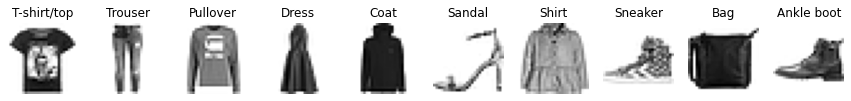

In [9]:
fig=plt.figure(figsize=(15,15))
rows=1
columns=10
for i in range(1, columns*rows +1):
    tg=sample[i-1]
    ax=fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(tg,cmap=plt.cm.binary)
    ax.title.set_text(class_label[i-1])
plt.show()

In [10]:
trainX=[train_X[i].flatten() for i in range(len(train_X))]
print(np.shape(trainX))
print(np.shape(trainY))

(60000, 784)
(60000,)


In [11]:
testX=[test_X[i].flatten() for i in range(len(test_X))]
np.shape(testX)
np.shape(testY)

(10000,)

In [12]:
train_samples=len(trainX)
test_samples=len(testX)
xlen=len(trainX[0])
print(xlen)

784


In [74]:
#No of Layers
L=3
#size of each hidden layer
N=8
#No of classes
K=10

In [75]:
def initialize_weights(n_input, n_hidden_layer, n_output,neurons_hl):
    W = list()
    W.append([[random() for j in range(n_input)]for i in range(neurons_hl)])
    for i in range(n_hidden_layer-1):
        W.append([[random() for j in range(neurons_hl)]for i in range(neurons_hl)])
    W.append([[random() for j in range(neurons_hl)]for i in range(n_output)])
    return W
W=initialize_weights(len(trainX[0]),L-1,K,N)

In [76]:
print(np.shape(W[0]))
print(np.shape(W[1]))
print(np.shape(W[2]))

(8, 784)
(8, 8)
(10, 8)


In [77]:
def initialize_bias(n_input, n_hidden_layer, n_output,neurons_hl):
    B=list()
    for i in range(n_hidden_layer):
        B.append([random() for i in range(neurons_hl)])
    B.append([random() for i in range(n_output)])
    return B
B= initialize_bias(len(trainX[0]),L-1,K,N)

In [78]:
print(np.shape(B[0]))
print(np.shape(B[1]))
print(np.shape(B[2]))

(8,)
(8,)
(10,)


In [79]:
def sigmoid(a):
  h=list()
  for el in a:
    h.append(1/(1+np.exp(-el)))
  return h

In [80]:
def softmax(a):
  h=list()
  sum=0
  for el in a:
    sum+=np.exp(el)
  for el in a:
    h.append(np.exp(el)/sum)
  return h

In [81]:
def feed_forward(input,W,B,L):
    H=list()
    A=list()
    H.append(input)
    A.append([0])
    h=input
    for i in range(1,L):
        a=B[i-1]+np.matmul(W[i-1],h)
        A.append(a)
        h=sigmoid(a)
        H.append(h)
    a=B[L-1]+np.matmul(W[L-1],h)
    A.append(a)
    hL=softmax(a)
    H.append(hL)
    return H,A,hL
H,A,y_hat=feed_forward(trainX[0],W,B,L)

In [82]:
y_hat

[0.09837579839569453,
 0.02592550662318777,
 0.06745693761329552,
 0.01879421839242963,
 0.045395745480341095,
 0.3026465477382499,
 0.011051839776773898,
 0.2153211515533974,
 0.05628811932300036,
 0.15874413510362997]

In [83]:
def cmp(e):
  g=1/(1+np.exp(-e))
  return g*(1-g)

In [84]:
def diff_sigmoid(a):
    res=list()
    for el in a:
      res.append(cmp(el))
    return res

In [85]:
def back_propogation(H,A,y_hat,label):
    W_grad=list()
    B_grad=list()
    one_hot_y=np.zeros(K)
    one_hot_y[label]+=1
    ak_grad = y_hat-one_hot_y
    for k in range(L,0,-1):
        w_grad=np.matmul(np.matrix(ak_grad).T,np.matrix(H[k-1]))
        W_grad.append(w_grad)
        B_grad.append(ak_grad)
        if k != 1:
            h_grad=np.matmul(np.transpose(W[k-1]),ak_grad)
            ak_grad=np.multiply(h_grad,diff_sigmoid(A[k-1]))
    return W_grad,B_grad
W_grad,B_grad=back_propogation(H,A,y_hat,trainY[0])
W_grad=W_grad[::-1]
B_grad=B_grad[::-1]

In [86]:
print(np.shape(W_grad[0]))
print(np.shape(W_grad[1]))
print(np.shape(W_grad[2]))

(8, 784)
(8, 8)
(10, 8)


In [87]:
print(np.shape(B_grad[0]))
print(np.shape(B_grad[1]))
print(np.shape(B_grad[2]))

(8,)
(8,)
(10,)


In [88]:
eta=0.0001

In [91]:
def gradient_descent():
    t=0
    max_iterations=20
    W= initialize_weights(xlen,L-1,K,N)
    B= initialize_bias(xlen,L-1,K,N)
    loss=list()
    while (t<max_iterations):
        eta_wgrad=list()
        eta_bgrad=list()
        for l in range(L):
            eta_wgrad.append(np.zeros(shape=np.shape(W[l])).tolist())
            eta_bgrad.append(np.zeros(shape=np.shape(B[l])).tolist())
        error=0.0
        for i in range(train_samples):
            H,A,y_hat=feed_forward(trainX[i],W,B,L)
            error+=(-math.log(y_hat[trainY[i]]))
            W_grad,B_grad=back_propogation(H,A,y_hat,trainY[i])
            W_grad=W_grad[::-1]
            B_grad=B_grad[::-1]
            for l in range(L):
                eta_wgrad[l]=(np.matrix(eta_wgrad[l])+np.multiply(eta,W_grad[l])).tolist()
                eta_bgrad[l]=(eta_bgrad[l]+np.multiply(eta,B_grad[l])).tolist()
        for l in range(L):
            W[l]=(np.matrix(W[l])-np.matrix(eta_wgrad[l])).tolist()
            B[l]=np.subtract(B[l],eta_bgrad[l])       
        loss.append(error)
        t=t+1
        print('Epoch',t)
    print (loss)
    return W,B,loss

In [ ]:
W,B,loss=gradient_descent()

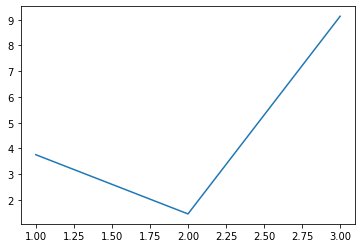

In [53]:
plt.plot([i+1 for i in range(8)],loss)

In [56]:
#Prediction
valid=0
for i in range(test_samples):
    H,A,y_hat = feed_forward(testX[i],W,B,L)
    class_predict = y_hat.index(max(y_hat))
    if(class_predict==testY[i]):
        valid += 1
Accuracy=valid/test_samples

In [57]:
Accuracy

0.1